This is me following instructions given to me so I could understand my topic through practice.

In [1]:
#Import statements
from osgeo import ogr, gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Find image dataset
#Get images in and processed
#Split image data into inputs and outputs
#Split into training set and testing set
#Train model
#Stonks

In [3]:
#global directories
source_path = 'E:\\ML\\satellite-image-analysis\\Satellite-image-sp\\sources'

In [4]:
#experiment 1 pt 1
shapes = ogr.Open(f'{source_path}\\1\\shapes.shp')
vec_layer = shapes.GetLayerByIndex(0)
defn = vec_layer.GetLayerDefn()
for i in range(defn.GetFieldCount()):
    field_defn = defn.GetFieldDefn(i)
    print('\t{name} - {datatype}'.format(name=field_defn.GetName(),
                                         datatype=field_defn.GetTypeName()))

	id - Integer64


In [5]:
#experiment 1 pt 2
#open
raster = gdal.Open(f'{source_path}\\1\\img.tif', gdal.GA_ReadOnly)
#get relevant attributes
ncol = raster.RasterXSize
nrow = raster.RasterYSize
proj = raster.GetProjectionRef()
ext = raster.GetGeoTransform()
#close file data to save space
raster = None
print(f'{ncol}, {nrow}')

5443, 1453


In [6]:
#experiment 1 pt 3
# Create the raster dataset
memory_driver = gdal.GetDriverByName('GTiff')
out_raster_ds = memory_driver.Create(f'{source_path}\\1\\training.tif', ncol, nrow, 1, gdal.GDT_Byte)
# Set the ROI projection and extent to match input
out_raster_ds.SetProjection(proj)
out_raster_ds.SetGeoTransform(ext)
# Fill output band with 0 blank, no class label, value
b = out_raster_ds.GetRasterBand(1)
b.Fill(0)
# Rasterize the shapefile layer
status = gdal.RasterizeLayer(out_raster_ds,  #output
                             [1],  #first band
                             vec_layer,  #referenced layer layer
                             None, None,  #No transforms
                             [0],  #burn value 0
                             ['ALL_TOUCHED=TRUE',  #rasterize all pixels touched by polygons
                              'ATTRIBUTE=id']  #match raster values to SHP ID values
                             )
# Close dataset
out_raster_ds = None

In [7]:
# Check ROI
roi_ds = gdal.Open(f'{source_path}\\1\\training.tif', gdal.GA_ReadOnly)
roi = roi_ds.GetRasterBand(1).ReadAsArray()
#Get list of pixels per class
classes = np.unique(roi)
#Print data
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c, n=(roi == c).sum()))

Class 0 contains 6433814 pixels
Class 1 contains 1072085 pixels
Class 2 contains 320974 pixels
Class 4 contains 81806 pixels


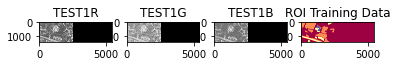

In [8]:
# View Images
#set up GDAL
gdal.UseExceptions()
gdal.AllRegister()
#open base and ROI
img_ds = gdal.Open(f'{source_path}\\1\\img.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open(f'{source_path}\\1\\training.tif', gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

#display
plt.subplot(141)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('TEST1R')

plt.subplot(142)
plt.imshow(img[:, :, 1], cmap=plt.cm.Greys_r)
plt.title('TEST1G')

plt.subplot(143)
plt.imshow(img[:, :, 2], cmap=plt.cm.Greys_r)
plt.title('TEST1B')

plt.subplot(144)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

In [9]:
#Experimentation: Training AI model pt 1
#get sample count
n_samples = (roi > 0).sum()
print(f'{n_samples} traning samples')

#get labels
labels = np.unique(roi[roi > 0])
print(f'The training data includes {labels.size} classes: {labels}')

1474865 traning samples
The training data includes 3 classes: [1 2 4]


In [10]:
#Get input and output
X = img[roi > 0, :] #ROI masking
Y = roi[roi > 0]
print(f'X is sized: {X.size}')
print(f'Y is sized: {Y.size}')
#Why is image flattened/is it important

X is sized: 4424595
Y is sized: 1474865


In [12]:
from sklearn.ensemble import RandomForestClassifier
# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=50, oob_score=True)
# Fit our model to training data
rf = rf.fit(X, Y)
print('success')

success


In [11]:
import pickle
pickle.dump(rf,open('testmodel.p', 'wb'))

NameError: name 'rf' is not defined

In [13]:
import pickle
from sklearn.metrics import accuracy_score
with open('testmodel.p','rb') as infile:
    model = pickle.load(infile)
prediction = model.predict(X)
score = accuracy_score(Y, prediction)
print(score)

0.9267817732470429


In [ ]:
#score = 0.92678